**<h1>DATA SCIENCE 2/3 SEMI-AUTO** 


<h1>Training ManualML Medische Data

<h3> Install dependencies

In [ ]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.5 MB 40 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.3-py2.py3-none-any.whl size=177541401 sha256=1f232a89cadb82d03fd7a03a65cf51ca4cdbdc6dcc093a51538e1aaf01379d3f
  Stored in directory: /root/.cache/pip/wheels/16/f8/f4/69e1ff6a0d1cb61bdbc0d9888ee8437a1acf1eb1c6ffb8be20
Successfully built h2o


<h3> Import Libraries

In [ ]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator, H2ORandomForestEstimator
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive')

Mounted at /content/gdrive


<h3> Initialize H2O

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpx4dxlebn
  JVM stdout: /tmp/tmpx4dxlebn/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpx4dxlebn/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_0df4kt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


<h3> Load data

In [ ]:
data= "/content/gdrive/My Drive/Datasets/Medische_dataset/medisch-centrum-randstad.csv"
data = pd.read_csv(data)
# Convert dataframe into H2O
data = h2o.H2OFrame(data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


<h3>Data Split

In [ ]:
# Split data into training and validation sets
train, valid = data.split_frame(ratios=[0.8])

<h3>Define list of base models

In [ ]:
base_models = [
    H2OGradientBoostingEstimator(ntrees=100, max_depth=4),
    H2ORandomForestEstimator(ntrees=100, max_depth=4)
]

<H3> Train base models on the training set

In [ ]:
for model in base_models:
    model.train(x=["genetic", "length", "mass", "exercise", "smoking", "alcohol", "sugar"], y="lifespan", training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


<h4> Predict val Data

In [ ]:
from h2o.frame import H2OFrame
# Generate predictions on the validation set using each base model
preds = [model.predict(valid) for model in base_models]

# Combine the predictions from the base models using a simple average
ensemble_preds = H2OFrame.round(sum(preds) / len(preds), digits = 0)


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
print(ensemble_preds.names)
print(valid["lifespan"].names)

['predict']
['lifespan']


In [ ]:
# Concatenate the predictions H2OFrame with the validation H2OFrame
ensemble_preds = ensemble_preds.cbind(valid["lifespan"])
print(ensemble_preds)

# print(ensemble_preds.cbind(valid["lifespan"]))
# Evaluate the accuracy of the stacked ensemble model
ensemble_acc = (ensemble_preds["predict"] == ensemble_preds["lifespan"]).mean()
print(f"mean: {ensemble_acc}")


  predict    lifespan
       74          69
       73          66
       65          64
       90          92
       79          75
       74          77
       70          70
       86          86
       69          71
       73          66
[827 rows x 2 columns]

mean: [0.1003627569528416]


<h3> Visualization

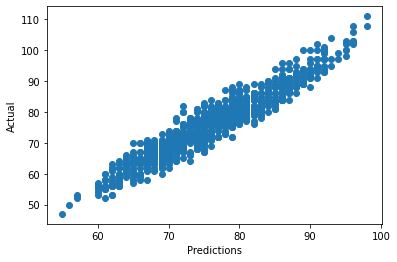

In [ ]:
import matplotlib.pyplot as plt

# Extract the values from the H2OFrame objects
predictions = ensemble_preds["predict"].as_data_frame()
actual = ensemble_preds["lifespan"].as_data_frame()

# Create a scatter plot of the predictions and actual values
plt.scatter(predictions, actual)
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.show()


<h3> Save Model

In [ ]:
h2o.save_model(model, "/content/gdrive/My Drive/Datasets/Medische_dataset/Medische_data_model_Manual.h2o")

'/content/gdrive/My Drive/Datasets/Medische_dataset/Medische_data_model_Manual.h2o/DRF_model_python_1671191447151_2'